In [2]:
import pandas as pd
import re
import yaml
import sqlparse
import os
import pandas as pd
import numpy as np
import requests
from IPython.display import display, Markdown

from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

In [3]:
def add_repo_root_path():
    import os
    import sys
    repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if repo_root not in sys.path:
        sys.path.append(repo_root)
        
add_repo_root_path()
from src import generate_knowledge
from src import create_rag_db
from src import llm_chain_tools
from src.enhanced_retriever import EnhancedRetriever

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', 10) 

### INIT

In [5]:
generate_knowledge.add_repo_root_path()
import openai_setup

OPENAI_API_KEY = openai_setup.conf['key']
OPENAI_PROJECT = openai_setup.conf['project']
OPENAI_ORGANIZATION = openai_setup.conf['organization']
DEFAULT_LLM_MODEL = "gpt-4o-mini"
CHROMADB_DIRECTORY = '../chromadb'
COLLECTION_NAME = "my_chromadb" 

import os
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ['OPENAI_MODEL_NAME'] = DEFAULT_LLM_MODEL


In [6]:
langchain_openai_embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY, model="text-embedding-ada-002")
langchain_openai_llm = ChatOpenAI(model=DEFAULT_LLM_MODEL, temperature=0.1, openai_api_key=OPENAI_API_KEY, openai_organization = OPENAI_ORGANIZATION)

In [7]:
# Define file paths for YAML configurations
files = {
    'agents': '../config/agents.yml',
    'tasks': '../config/tasks.yml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
agents_config = configs['agents']
tasks_config = configs['tasks']

print(agents_config)
print(tasks_config)

{'interpretation_agent': {'role': 'Request Interpreter\n', 'goal': 'Interpret user requests related to dbt projects and translate them into actionable decisions. Use expertise in dbt, data modeling, and analytics engineering to determine the type of action required.\n', 'backstory': "You specialize in analyzing requests to identify whether the action involves adding a field, modifying an existing model, or retrieving specific information. Your goal is to provide concise and actionable outputs tailored to the user's needs.\n", 'verbose': True, 'allow_delegation': False}, 'evaluation_agent': {'role': 'Evaluation Specialist\n', 'goal': 'Evaluate user requests related to dbt projects and provide concise, actionable insights and steps required to address the request. Leverage expertise in data modeling, dbt project structure, and dependency analysis to ensure accurate evaluations.\n', 'backstory': 'You specialize in analyzing interpreted requests and breaking them down into specific, action

In [8]:
from crewai import Agent, Task, Crew

### TESTS

#### Agents

In [8]:

# Creating Agents
interpretation_agent = Agent(
  config=agents_config['interpretation_agent'],
)

evaluation_agent = Agent(
  config=agents_config['evaluation_agent'],
)

lineage_agent = Agent(
  config=agents_config['lineage_agent'],
)

plan_agent = Agent(
  config=agents_config['plan_agent'],
)

In [9]:
# Creating Tasks
interpretation_task = Task(
  config=tasks_config['interpretation_task'],
  agent=interpretation_agent
)

evaluation_task = Task(
  config=tasks_config['evaluation_task'],
  agent=evaluation_agent
)

lineage_task = Task(
  config=tasks_config['lineage_task'],
  agent=lineage_agent
)

plan_task = Task(
  config=tasks_config['plan_task'],
  agent=plan_agent
)

In [10]:
crew = Crew(
  agents=[
    interpretation_agent,
    evaluation_agent
  ],
  tasks=[
    interpretation_task,
    evaluation_task
  ],
  verbose=True
)

In [11]:
user_input = 'Give me all the information about the models related with customers'

inputs = {
  'request': user_input
}

# Run the crew
result = crew.kickoff(
  inputs=inputs
)

ValueError: Missing required template variable 'interpretation' in description

#### Flows

In [17]:
import nest_asyncio
nest_asyncio.apply()

In [12]:
from crewai import Flow
from crewai.flow.flow import listen, start

class dbtChatFlow(Flow):
    @start()
    def interpret_prompt(self):
        user_prompt = self.state["user_input"]
        print(user_prompt)
        interpretation_result = crew.kickoff(inputs = {'request': user_prompt} )
        self.state["interpretation_result"] = interpretation_result
        return interpretation_result

    @listen(lambda state: "interpretation_result" in state)
    def evaluate_interpretation(self):
        interpretation_result = self.state.get("interpretation_result")
        evaluation_result = crew.agents[1].kickoff({"request": interpretation_result})
        self.state["evaluation_result"] = evaluation_result
        return evaluation_result

flow = dbtChatFlow()
#flow.plot()

In [13]:
user_input = 'Give me all the information about the models related with customers'
flow.kickoff(inputs={"user_input": user_input})

Give me all the information about the models related with customers
# Agent: Request Interpreter
## Task: Evaluate the user's request: Give me all the information about the models related with customers and determine the required action: - Adding a field: Identify where the field is currently available (if provided),
  determine how to propagate it through necessary models or transformations,
  and assess the impact on related models and dependencies.
- Modifying an existing model: Identify specific changes needed, evaluate the
  impact on structure, relationships, and downstream dependencies.
- Retrieving specific information: Identify models containing relevant data,
  analyze relationships, and determine queries or transformations needed.

Reflect on the request to generate a concise plan for the approach and provide a clear summary of the required action and its implications.



# Agent: Request Interpreter
## Final Answer: 
RETRIEVE_INFO - The user is requesting all information ab

CrewOutput(raw="To fulfill the user request for all information about models related to customers, follow these high-level actionable steps:\n\n1. **Identify Target Models or Files**: \n   - Locate and list all dbt models that contain customer-related data. This could include models directly named 'customers' as well as any associated models such as 'customer_orders', 'customer_segments', or 'customer_addresses'.\n\n2. **Analyze Dependencies and Relationships**: \n   - Examine upstream and downstream dependencies for each identified model using dbt's lineage graph. Document which models feed into customer-related models and which models derive data from them.\n\n3. **Field Existence Evaluation**: \n   - Check the schema of each customer-related model to ensure that all necessary fields (e.g., customer ID, name, contact information) are present and correctly defined.\n\n4. **Assess Documentation Needs**: \n   - Review existing documentation for the identified models. Identify gaps in do

### CREATE AGENT CHAIN

#### Configure Prerequisites

In [9]:
from langchain_openai import ChatOpenAI

loaded_vectorstore = Chroma(
    collection_name=COLLECTION_NAME,
    persist_directory=CHROMADB_DIRECTORY,
    embedding_function=langchain_openai_embeddings
)

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_42658/2024057643.py:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  loaded_vectorstore = Chroma(


In [10]:
_, repo_name = generate_knowledge.extract_owner_and_repo('https://github.com/dbt-labs/jaffle-shop')
dbt_models_df = pd.read_csv('../data/dbt_models_' + repo_name + '.csv')
dbt_project_df = pd.read_csv('../data/dbt_project_' + repo_name + '.csv')
dbt_repo_knowledge_df = create_rag_db.merge_dbt_models_and_project_dfs(dbt_models_df, dbt_project_df)

In [11]:
retriever = EnhancedRetriever(vectorstore = loaded_vectorstore, embedding_function= langchain_openai_embeddings)

query = "give me all the models related with the dbt model orders"
final_context, top_documents = retriever.retrieve(query)

#### Create agents, tasks and flow

In [12]:
# Creating Agents
interpretation_agent = Agent(
  config=agents_config['interpretation_agent'],
)

evaluation_agent = Agent(
  config=agents_config['evaluation_agent'],
)

lineage_agent = Agent(
  config=agents_config['lineage_agent'],
)

plan_agent = Agent(
  config=agents_config['plan_agent'],
)

In [13]:
# Creating Tasks
interpretation_task = Task(
  config=tasks_config['interpretation_task'],
  agent=interpretation_agent
)

evaluation_task = Task(
  config=tasks_config['evaluation_task'],
  agent=evaluation_agent
)

lineage_task = Task(
  config=tasks_config['lineage_task'],
  agent=lineage_agent
)

plan_task = Task(
  config=tasks_config['plan_task'],
  agent=plan_agent
)

In [14]:
interpretation_crew = Crew(agents = [interpretation_agent], tasks = [interpretation_task], verbose = True)
evaluation_crew = Crew(agents = [evaluation_agent], tasks = [evaluation_task], verbose = True)
lineage_crew = Crew(agents = [lineage_agent], tasks = [lineage_task], verbose = True)
plan_crew = Crew(agents = [plan_agent], tasks = [plan_task], verbose = True)

Overriding of current TracerProvider is not allowed
Overriding of current TracerProvider is not allowed
Overriding of current TracerProvider is not allowed


In [ ]:
import nest_asyncio
nest_asyncio.apply()

from crewai import Flow
from crewai.flow.flow import listen, start

class dbtChatFlow(Flow):
    @start()
    def interpret_prompt(self):
        request = self.state["request"]
        interpretation = interpretation_crew.kickoff(inputs = {'request': request})
        self.state["interpretation"] = interpretation
        return interpretation

    @listen(interpret_prompt)
    def evaluate_interpretation(self):
        request = self.state["request"]
        interpretation = self.state.get("interpretation")
        evaluation = evaluation_crew.kickoff(inputs = {'request': request, "interpretation": interpretation})
        self.state["evaluation"] = evaluation
        return evaluation
    
    @listen(evaluate_interpretation)
    def retrieve_general_context_for_lineage_calculation(self):
        request = self.state["request"]
        vectorstore = self.state["vectorstore"]
        embedding_function = self.state["embedding_function"]
        retriever = EnhancedRetriever(vectorstore = vectorstore, embedding_function= embedding_function)
        retrieved_context, retrieved_documents = retriever.retrieve(request)
        retrieved_context = "\n".join([doc.page_content for doc in retrieved_documents if hasattr(doc, 'page_content')])
        self.state["retrieved_context"] = retrieved_context
        return retrieved_context

    @listen(retrieve_general_context_for_lineage_calculation)
    def get_lineage(self):
        request = self.state["request"]
        evaluation = self.state.get("evaluation")
        
        retrieved_context = self.state.get("retrieved_context")
        lineage_analysis = lineage_crew.kickoff(inputs = {'request': request, 'evaluation': str(evaluation), 'retrieved_context':retrieved_context})
        json_output = lineage_analysis.raw.replace("```json", "").replace("```", "").strip()
        self.state["lineage_analysis"] = eval(json_output)
        return eval(json_output)
    
    @listen(get_lineage)
    def get_lineage_documents(self):
        lineage_analysis = self.state.get("lineage_analysis")
        vectorstore = self.state["vectorstore"]
        dbt_repo_knowledge_df = self.state["dbt_repo_knowledge_df"]

        model_name = lineage_analysis.get("model")
        scope = lineage_analysis.get("scope", "").upper()

        lineage_df = create_rag_db.plot_dbt_lineage(dbt_repo_knowledge_df)
        affected_models = llm_chain_tools.get_affected_models(lineage_df, model_name)

        if scope == "UP":
            filtered_models = affected_models["upstream"]
        elif scope == "DOWN":
            filtered_models = affected_models["downstream"]
        elif scope == "ALL":
            filtered_models = affected_models["upstream"] + affected_models["downstream"]
        filtered_models = list(set(f"{model}.sql" for model in filtered_models + [model_name]))
        
        documents = llm_chain_tools.extract_documents_from_vectorstore(vectorstore)
        selected_documents = llm_chain_tools.select_documents(documents, filtered_models)
        self.state["lineage_documents"] = selected_documents
        return selected_documents

flow = dbtChatFlow()
flow.plot()

Plot saved as crewai_flow.html


# Agent: Request Interpreter
## Task: Evaluate the user's request: Give me all the information about the models related with customers and based on the evaluation, determine the required action: 1) adding a field -> return ADD_COLUMN 2) modifying an existing model -> return MODIFY_MODEL 3) retrieving and returning specific information. -> return RETRIVE_INFO
Reflect on the request and provide a concise plan for the approach: - If the action involves adding a field: Identify where the field is currently available, if provided. - Determine how to propagate the field through the necessary models or transformations to integrate it into the target model. - Consider the impact on related models and dependencies. - If the action involves modifying an existing model: Identify the specific changes required. - Assess how these changes affect the structure, relationships, and downstream dependencies of the model. - If the action involves retrieving or returning information: Identify the models co

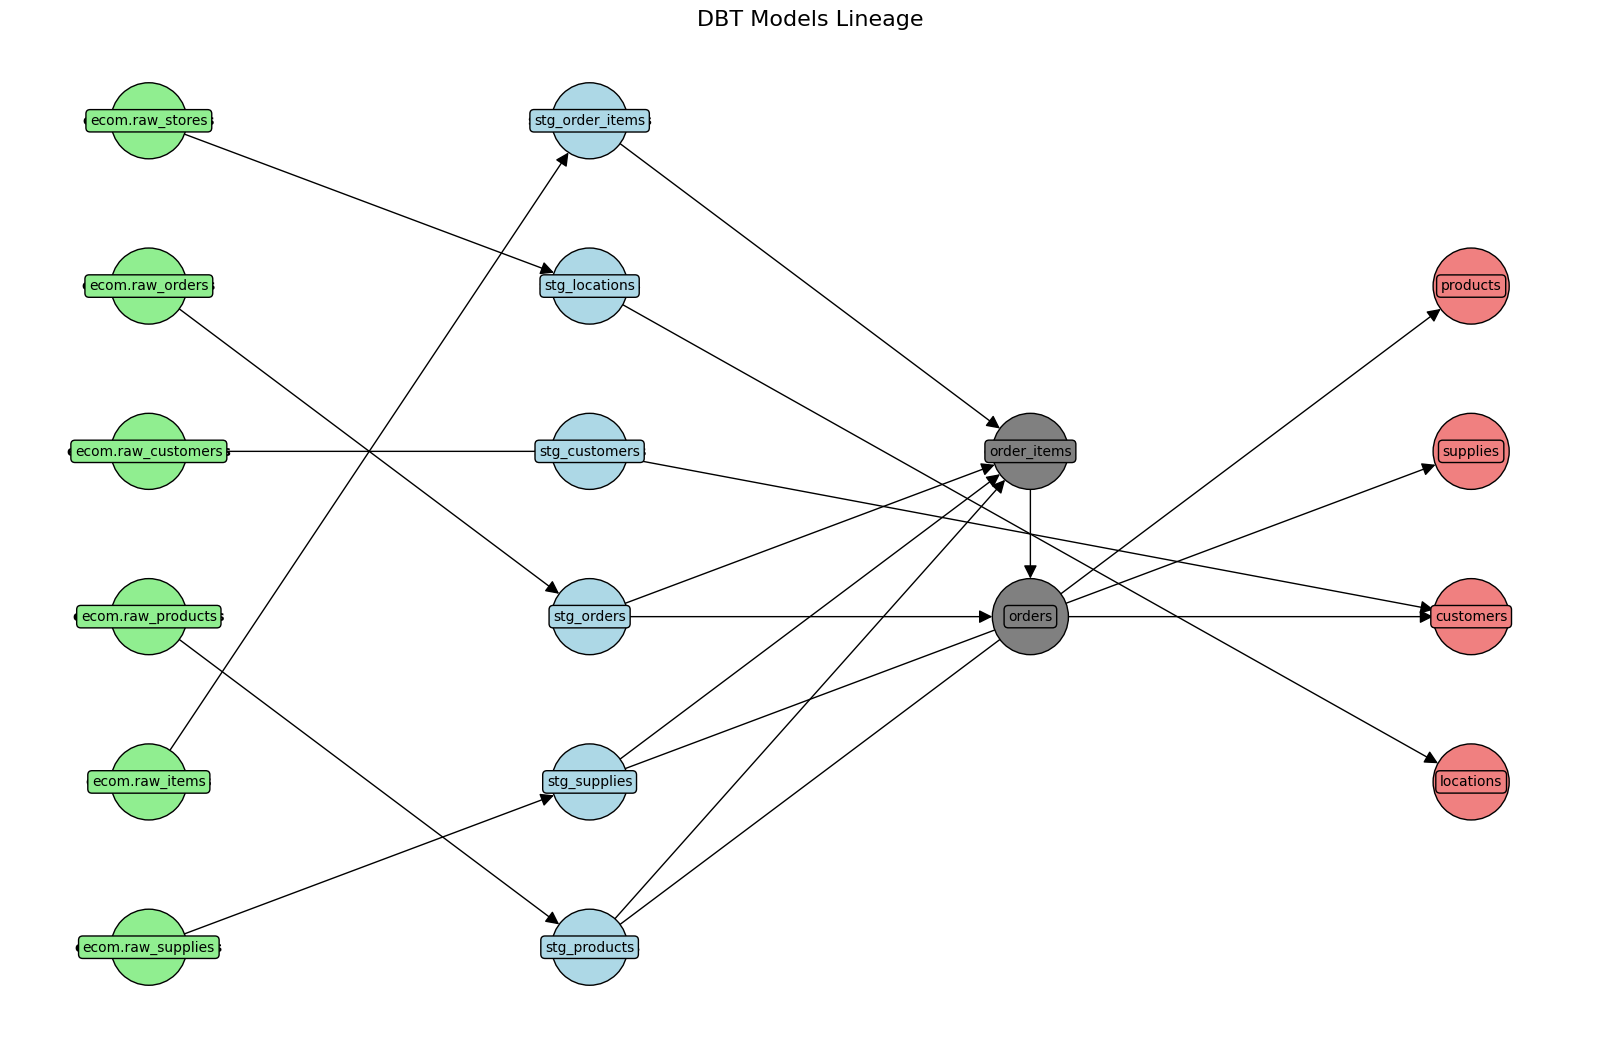

['stg_orders.sql', 'stg_order_items.sql', 'customers.sql', 'ecom.raw_products.sql', 'ecom.raw_items.sql', 'orders.sql', 'stg_products.sql', 'ecom.raw_orders.sql', 'stg_customers.sql', 'ecom.raw_customers.sql', 'stg_supplies.sql', 'ecom.raw_supplies.sql', 'order_items.sql']


In [35]:
user_input = 'Give me all the information about the models related with customers'
result = flow.kickoff(inputs={"request": user_input, "dbt_repo_knowledge_df": dbt_repo_knowledge_df, "vectorstore": loaded_vectorstore, "embedding_function":langchain_openai_embeddings})

In [37]:
result

{'retriever_documents': [Document(metadata={'children': "['customers']", 'has_group_by': False, 'has_select_all_in_last_select': True, 'has_tests': True, 'is_end_model': False, 'is_filtered': False, 'is_macro': '', 'is_seed': '', 'is_snapshot': False, 'is_source_model': True, 'is_test': '', 'knowledge_type': 'models', 'model_category': 'stg', 'name': 'stg_customers.sql', 'packages': '', 'parents': '[]', 'path': 'models/staging/stg_customers.sql', 'source': "['ecom.raw_customers']", 'vertical': 'customers'}, page_content="<MODEL CODE>:\n        .sql Code:\n        WITH SOURCE AS\n  (SELECT *\n   FROM {{ source('ecom', 'raw_customers') }}), renamed AS\n  (SELECT ----------  ids\n id AS customer_id, ---------- text\n name AS customer_name\n   FROM SOURCE)\nSELECT *\nFROM renamed"),
  Document(metadata={'children': "['customers']", 'has_group_by': False, 'has_select_all_in_last_select': True, 'has_tests': True, 'is_end_model': False, 'is_filtered': False, 'is_macro': '', 'is_seed': '', 'is

#### Example

In [ ]:
from crewai import Flow
from crewai.flow.flow import listen, start, and_, or_, router

class SalesPipeline(Flow):
    
  @start()
  def fetch_leads(self):
    # Pull our leads from the database
    # This is a mock, in a real-world scenario, this is where you would
    # fetch leads from a database
    leads = [
      {
        "lead_data": {
          "name": "João Moura",
          "job_title": "Director of Engineering",
          "company": "Clearbit",
          "email": "joao@clearbit.com",
          "use_case": "Using AI Agent to do better data enrichment."
        },
      },
    ]
    return leads

  @listen(fetch_leads)
  def score_leads(self, leads):
    scores = lead_scoring_crew.kickoff_for_each(leads)
    self.state["score_crews_results"] = scores
    return scores

  @listen(score_leads)
  def store_leads_score(self, scores):
    # Here we would store the scores in the database
    return scores

  @listen(score_leads)
  def filter_leads(self, scores):
    return [score for score in scores if score['lead_score'].score > 70]

  @listen(and_(filter_leads, store_leads_score))
  def log_leads(self, leads):
    print(f"Leads: {leads}")

  @router(filter_leads, paths=["high", "medium", "low"])
  def count_leads(self, scores):
    if len(scores) > 10:
      return 'high'
    elif len(scores) > 5:
      return 'medium'
    else:
      return 'low'

  @listen('high')
  def store_in_salesforce(self, leads):
    return leads

  @listen('medium')
  def send_to_sales_team(self, leads):
    return leads

  @listen('low')
  def write_email(self, leads):
    scored_leads = [lead.to_dict() for lead in leads]
    emails = email_writing_crew.kickoff_for_each(scored_leads)
    return emails

  @listen(write_email)
  def send_email(self, emails):
    # Here we would send the emails to the leads
    return emails